<a href="https://colab.research.google.com/github/MichaelArthur224/Stroke_Prediction/blob/main/Stroke_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Stroke Prediction Classification

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

![](https://drive.google.com/uc?export=view&id=1m9sBk8UlQ08td6HiHUuly8SV3WRNtdiw)

##Import Data

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Stroke/healthcare-dataset-stroke-data.csv')
df1 = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [85]:
#Check class balance
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [86]:
#we will have to adjust data for no bias
df.shape

(5110, 12)

In [87]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [88]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

##Cleaning

In [89]:
df.duplicated().sum()

0

In [90]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [91]:
# filled missing bmi with average
df.fillna({"bmi":df['bmi'].mean().round(1)}, inplace=True)
df['bmi'].head()

0    36.6
1    28.9
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64

In [92]:
# drop 1 patient with other for gender 
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [93]:
print(df[df['gender']=='Other'].index.values)

[3116]


In [94]:
df = df.drop(3116)
df['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

##EDA

<Axes: xlabel='heart_disease', ylabel='age'>

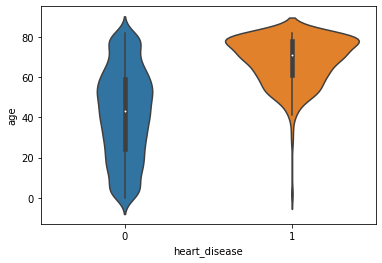

In [127]:
sns.violinplot(data=df, x='heart_disease', y='age')

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
You can see that people of older age have heart disease, meanwhile the amount of younger people without heart disease is greater

<Axes: xlabel='stroke', ylabel='avg_glucose_level'>

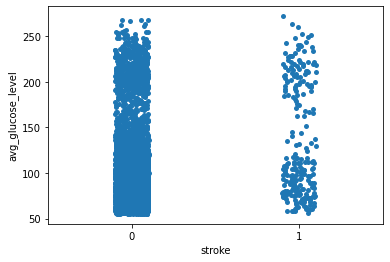

In [128]:
sns.stripplot(data=df, x='stroke', y='avg_glucose_level')

stroke: 1 if the patient had a stroke or 0 if not
The amount of people with a glucose level around 150 seem to have the least amount of strokes

##Prepare data

In [95]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [96]:
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})

In [97]:
replacement_dictionary = {'never smoked':0, 'Unknown':1, 'formerly smoked':2, 'smokes':3}
df['smoking_status'].replace(replacement_dictionary, inplace=True)

In [98]:
X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [99]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [100]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [101]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

In [102]:
preprocessor = make_column_transformer(number_tuple, category_tuple)

In [103]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##Solving Imbalance

In [104]:
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [105]:
under_sampler = RandomUnderSampler()
under_sample_pipe = make_sampler_pipeline(scaler, under_sampler)
X_train_under, y_train_under = under_sample_pipe.fit_resample(X_train_processed, y_train)

##Tune Model

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [107]:
#create and visualize our parameter grid
param_grid = {'max_depth': [1,2,3], 'min_samples_leaf': [3,15,20], 'min_samples_split': [2, 10, 100]}
pd.DataFrame(param_grid).T

,0,1,2
max_depth,1,2,3
min_samples_leaf,3,15,20
min_samples_split,2,10,100


In [108]:
model = DecisionTreeClassifier()
param_grid = {'max_depth': [1,2,3], 'min_samples_leaf': [3,15,20], 'min_samples_split': [2, 10, 100]}

In [109]:
dt_grid_search = GridSearchCV(model, param_grid)
dt_grid_search.fit(X_train_under, y_train_under)
y_pred = dt_grid_search.predict(X_test_processed)

In [110]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.79      1198
           1       0.14      0.85      0.24        80

    accuracy                           0.67      1278
   macro avg       0.56      0.75      0.51      1278
weighted avg       0.93      0.67      0.75      1278



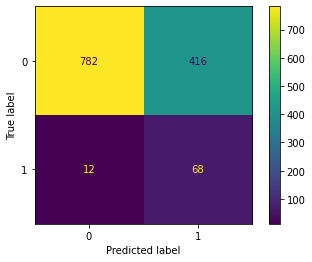

In [112]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

##DecisionTreeClassifier

In [113]:
#starting at 2
dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=5)
dec_tree.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [114]:
dec_pred = dec_tree.predict(X_test_processed)
train_score = dec_tree.score(X_train_under, y_train_under)
test_score = dec_tree.score(X_test_processed, y_test)
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Train Score: 0.8727810650887574
Test Score: 0.6525821596244131


In [115]:
print(classification_report(y_test, dec_pred))

              precision    recall  f1-score   support

           0       0.98      0.64      0.78      1198
           1       0.13      0.80      0.22        80

    accuracy                           0.65      1278
   macro avg       0.55      0.72      0.50      1278
weighted avg       0.93      0.65      0.74      1278



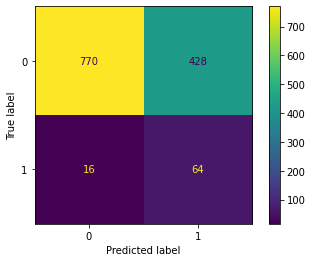

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, dec_pred)

##KNN W/ PCA

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [139]:
knn = KNeighborsClassifier(n_neighbors=3)

In [130]:
scaled_df_pca = scaler.fit_transform(X_train_under, y_train_under)
pca = PCA(n_components=2)
pca.fit(scaled_df_pca)

PCA(n_components=2)

In [140]:
knn_pipe_pca = make_pipeline (scaler, PCA(2), KNeighborsClassifier())
knn_pipe_pca.fit(X_train_under, y_train_under)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [141]:
preds_pca = knn_pipe_pca.predict(X_test_processed)
acc_score_pca = knn_pipe_pca.score(X_test_processed, y_test)
acc_score_pca

0.7050078247261345

In [133]:
pipe_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),'kneighborsclassifier__p': range(1,5),'kneighborsclassifier__weights': ['distance','uniform']}

In [134]:
knn_pipe_gs = GridSearchCV(knn_pipe_pca, pipe_param_grid)
knn_pipe_gs.fit(X_train_under, y_train_under)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test_processed, y_test)}')

Accuracy of best KNN model is: 0.715962441314554


In [135]:
print(classification_report(y_test, preds_pca))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      1198
           1       0.09      0.41      0.15        80

    accuracy                           0.71      1278
   macro avg       0.52      0.57      0.49      1278
weighted avg       0.89      0.71      0.78      1278



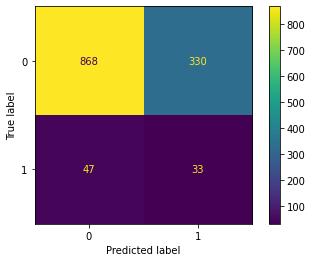

In [136]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_pca)

##Final Evaluation

In [138]:
print(f'KNN W/ PCA score: {acc_score_pca}')
print(f'Decision Tree score: {test_score}')

KNN W/ PCA score: 0.7050078247261345
Decision Tree score: 0.6525821596244131
